#### Originally from https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-05-09-Clustering-with-Scikit-with-GIFs.ipynb

It's a common task for a data scientist: you need to generate segments (or clusters- I'll use the terms interchangably) of the customer base. Where does one start? With definitions, of course!!! Clustering is the subfield of unsupervised learning that aims to partition unlabelled datasets into consistent groups based on some shared unknown characteristics. All the tools you'll need are in Scikit-Learn, so I'll leave the code to a minimum. Instead, through the medium of GIFs, this tutorial will describe the most common techniques. If GIFs aren't your thing (what are you doing on the internet?), then the [scikit clustering documentation](http://scikit-learn.org/stable/modules/clustering.html) is quite thorough.


# Techniques

Clustering algorithms can be broadly split into two types, depending on whether the number of segments is explicitly specified by the user. As we'll find out though, that distinction can sometimes be a little unclear, as some algorithms employ parameters that act as proxies for the number of clusters. But before we can do anything, we must load all the required modules in our python script. We also need to construct toy datasets to illustrate and compare each technique. The significance of each one will hopefully become apparent. 

You can download this jupyter notebook [here]() and the gifs can be downloaded from [this folder](https://github.com/dashee87/dashee87.github.io/tree/master/images) (or you can just right click on the GIFs and select 'Save image as...').

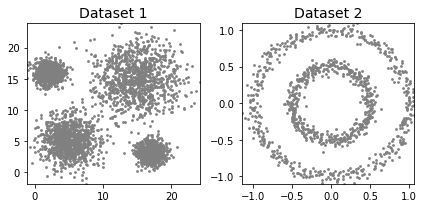

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# plot clustering output on the two datasets
def cluster_plots(set1, set2, colours1 = 'gray', colours2 = 'gray', 
                  title1 = 'Dataset 1',  title2 = 'Dataset 2'):
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours1)
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
    fig.tight_layout()
    plt.show()

cluster_plots(dataset1, dataset2)

## K-means

Based on absolutely no empirical evidence (the threshold for baseless assertions is much lower in blogging than academia), [k-means](https://en.wikipedia.org/wiki/K-means_clustering) is probably the most popular clustering algorithm of them all. The algorithm itself is relatively simple: Starting with a pre-specified number of cluster centres (which can be distributed randomly or smartly (see `kmeans++`)), each point is initally assigned to its nearest centre. In the next step, for each segment, the centres are moved to the centroid of the clustered points. The points are then  reassigned to their nearest centre. The process is repeated until moving the centres derives little or no improvement (measured by the within cluster sum of squares- the total squared distance between each point and its cluster centre). The alogorithm is concisely illustrated by the GIF below.

![title](https://dashee87.github.io/images/kmeans.gif)

Variations on the k-means algorithm include [k-medoids](https://en.wikipedia.org/wiki/K-medoids) and [k-medians](https://en.wikipedia.org/wiki/K-medians_clustering), where centroids are updated to the [medoid](https://en.wikipedia.org/wiki/Medoid) and median of existng clusters, repsectively. Note that, under k-medoids, cluster centroids must correspond to the members of the dataset. Alogorithms in the k-means family are sensitive to the starting position of the cluster centres, as each method converges to local optima, the frequency of which increase in higher dimensions. This issue is illustrated for k-means in the GIF below.

![title](https://dashee87.github.io/images/kmeans_bad.gif)

k-means clustering in scikit offers several extensions to the traditional approach. To prevent the alogrithm returning sub-optimal clustering, the kmeans method includes the `n_init` and `method` parameters. The former just reruns the algorithm with n different initialisations and returns the best output (measured by the within cluster sum of squares). By setting the latter to 'kmeans++' (the default), the initial centres are smartly selected (i.e. better than random). This has the additional benefit of decreasing runtime (less steps to reach convergence).

Dataset1
Cluster 0: 1022
Cluster 1: 1018
Cluster 2: 952
Cluster 3: 1008


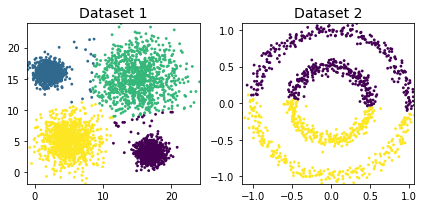

In [2]:
# implementing k-means clustering
kmeans_dataset1 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(dataset1)
kmeans_dataset2 = cluster.KMeans(n_clusters=2, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(dataset2)
print('Dataset1')
print(*["Cluster "+str(i)+": "+ str(sum(kmeans_dataset1==i)) for i in range(4)], sep='\n')
cluster_plots(dataset1, dataset2, 
              kmeans_dataset1, kmeans_dataset2)

k-means performs quite well on ``Dataset1``, but fails miserably on ``Dataset2``. In fact, these two datasets illustrate the strenghts and weaknesses of k-means. The algorithm seeks and identifies globular (essentially spherical) clusters. If this assumption doesn't hold, the model output may be inadaquate (or just really bad). It doesn't end there; k-means can also underperform with clusters of different size and density.

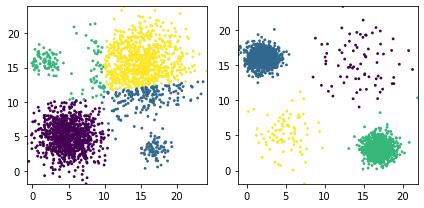

In [3]:
kmeans_dataset1 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(np.vstack([dataset1[:2080,:],
                                                                                    dataset1[3000:3080,:]]))
kmeans_dataset2 = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(np.vstack([dataset1[-2080:,],
                                                                                    dataset1[:80,]]))
cluster_plots(np.vstack([dataset1[:2080,],dataset1[3000:3080,]]), 
              np.vstack([dataset1[-2080:,],dataset1[:80,]]), 
              kmeans_dataset1, kmeans_dataset2,title1='', title2='')

For all its faults, the enduring popularity of k-means (and related algorithms) stems from its versatility. Its average complexity is O(k*n*T), where k,n and T are the number of clusters, samples and iterations, respectively. As such, it's considered one of the [fastest clustering algorithms out there](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). And in the world of big data, this matters. If your boss wants 10 customer segments by close of business, then you'll probably use k-means and just hope no one knows the word [globular](https://www.merriam-webster.com/dictionary/globular). 

# Gaussian Mixture models

This technique is the application of the [general expectation maximisation (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) to the task of clustering using Gaussian mixture models. It is conceptually related and visually similar to k-means (see GIF below). Where k-means seeks to minimise the distance between the observations and their assigned centroids, EM in this case is used to estimate the means and covariances of a mutltivariate normal distributions (called [Gaussian Mixture Models (GMM)](http://scikit-learn.org/stable/modules/mixture.html))), so as to maximise the log-likelihood of the observed data. Similar to k-means, the algorithm converges to the final clustering by iteratively improving its performance (i.e. reducing the log-likelihood). However, again like k-means, there is no guarantee that the algorithm has settled on the global minimum rather than local minimum (a concern that increases in higher dimensions).

![title](https://dashee87.github.io/images/em_only.gif)

In contrast to kmeans, observations are not explicitly assigned to clusters, but rather given probabilities of belonging to each distribution. If the underlying distribution is correctly identified (e.g. normal distribution in the GIF), then the algorithm performs well. In practice, especially for large datasets, the underlying distribution may not be retrievble, so EM clustering may not be well suited to such tasks.

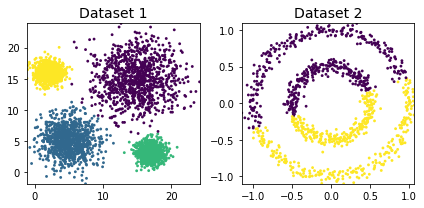

In [4]:
# implementing Guassian Mixture Models
em_dataset1 = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(dataset1)
em_dataset2 = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(dataset2)
cluster_plots(dataset1, dataset2, em_dataset1.predict(dataset1),  em_dataset2.predict(dataset2))

No surprises there. EM clusters the first dataset perfectly, as the underlying data is normally distributed. In contrast, `Dataset2` cannot be accurately modelled as a GMM, so that's why EM performs so poorly in this case.

# Hierarchical Clustering

Unlike k-means and EM, [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) (HC) doesn't require the user to specify the number of clusters beforehand. Instead it returns an output (typically as a dendrogram- see GIF below), from which the user can decide the appropriate number of clusters (either manually or [algorithmically](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)). If done manually, the user may cut the dendrogram where the merged clusters are too far apart (represented by a long lines in the dendrogram). Alternatively, the user can just return a specific number of clusters (similar to k-means).

![title](https://dashee87.github.io/images/hierarch.gif)

As its name suggests, it constructs a hierarchy of clusters based on proximity (e.g Euclidean distance or Manhattan distance- see GIF below). HC typically comes in two flavours (essentially, bottom up or top down): 

* Divisive: Starts with the entire dataset comprising one cluster that is iteratively split- one point at a time- until each point forms its own cluster.
* Agglomerative: The agglomerative method in reverse- individual points are iteratively combined until all points belong to the same cluster.

Another important concept in HC is the linkage criterion. This defines the distance between clusters as a function of the points in each cluster and determines which clusters are merged/split at each step. That clumsy sentence is neatly illustrated in the GIF below.

![title](https://dashee87.github.io/images/hierarch_1.gif)

Dataset 1
Cluster 0: 990
Cluster 1: 1008
Cluster 2: 1002
Cluster 3: 1000


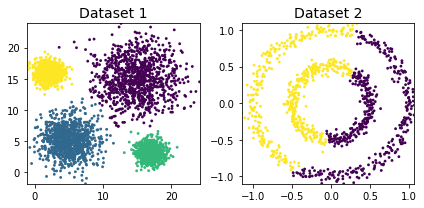

In [5]:
# implementing agglomerative (bottom up) hierarchical clustering
# we're going to specify that we want 4 and 2 clusters, respectively
hc_dataset1 = cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', 
                                              linkage='ward').fit_predict(dataset1)
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='average').fit_predict(dataset2)
print("Dataset 1")
print(*["Cluster "+str(i)+": "+ str(sum(hc_dataset1==i)) for i in range(4)], sep='\n')
cluster_plots(dataset1, dataset2, hc_dataset1, hc_dataset2)

You might notice that HC didn't perform so well on the noisy circles. By imposing simple connectivity constraints (points can only cluster with their n(=5) nearest neighbours), HC captures the non-globular structures within the dataset.

/anaconda/envs/wm01-tiger/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:549: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


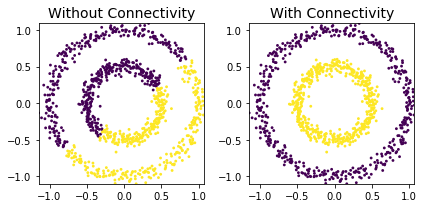

In [6]:
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='complete').fit_predict(dataset2)
connect = kneighbors_graph(dataset2, n_neighbors=5, include_self=False)
hc_dataset2_connectivity = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                              linkage='complete',connectivity=connect).fit_predict(dataset2)
cluster_plots(dataset2, dataset2,hc_dataset2,hc_dataset2_connectivity,
             title1='Without Connectivity', title2='With Connectivity')

Conveniently, the position of each observation isn't necessary for HC, but rather the distance between each point (e.g. a n x n matrix). However, the main disadvantage of HC is that it requires too much memory for large datasets (that n x n matrix blows up pretty quickly). Divisive clustering is $O(2^n)$, while agglomerative clustering comes in somewhat better at $O(n^2 log(n))$ (though special cases of $O(n^2)$ are available for single and maximum linkage agglomerative clustering).

# Mean Shift

Mean shift describes a [general non-parametric technique](https://en.wikipedia.org/wiki/Mean_shift) that locates the maxima of density functions, where Mean Shift Clustering simply refers to its application to the task of clustering. In other words, locate the density function maxima (mean shift algorithm) and then assign points to the nearest maxima. In that sense, it shares some similarities with k-means (the density maxima correspond to the centroids in the latter). Interestingly, the number of clusters is not required for its implementation and, as it's density based, it can detect clusters of any shape. Instead, the algorithm relies on a bandwidth parameter, which simply determines the size of neighbourhood over which the density will be computed. A small bandwidth could generate excessive clusters, while a high value could erroneously combine multiple clusters. Luckily, sklearn includes an [estimate_bandwidth function](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html). It uses the [k-nearest neighbours](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (kNN) algorithm to determine an optimal bandwidth value. I suppose that makes it even easier than k-means to implement. 

![title](https://dashee87.github.io/images/mean_shift_0.gif)

[Originally invented in 1975](http://ieeexplore.ieee.org/document/1055330/), mean shift gained prominence when it was successfully applied to computer vision (seminal paper [#1](http://ieeexplore.ieee.org/document/400568/) [#2](https://dx.doi.org/10.1109%2F34.1000236)). I won't discuss the underlying maths (that info can be found [here](https://saravananthirumuruganathan.wordpress.com/2010/04/01/introduction-to-mean-shift-algorithm/) and [here](http://efavdb.com/mean-shift/)). Intuitively, cluster centers are initially mapped onto the dataset randomly (like k-means). Around each centre is a ball (the radius of which is determined by the bandwidth), where the density equates to the number of points inside each ball. The centre of the ball is iteratively nudged towards regions of higher density by shifting the centre to the mean of the points within the ball (hence the name). This process is repeated until balls exhibit little movement. When multiple balls overlap, the ball containing the most points is preserved. Observations are then clustered according to their ball. Didn't follow that? Well, here's the gif.

![title](https://dashee87.github.io/images/mean_shift_tutorial.gif)

Now, you might be thinking "An algorithm that needs absolutely no input from the user and can detect clusters of any shape!!! This should be all over Facebook!!!". First of all, there's no guarantee that the value returned by estimate_bandwidth is appropriate (a caveat that becomes more pertinent in higher dimensions). Speaking of high dimensionality, mean shift may also converge to local optima rather than global optima. But the biggest mark against Mean Shift is its computational expense. It runs at $O(T*n^2)$, compared to $O(k*n*T)$ for k-means, where T is number of iterations and n represents the number of points. In fact, [according to the sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift), the `estimate_bandwidth` function scales particularly badly. Maybe humans (and data science blogs) will still be needed for a few more years!

Dataset1: 4 clusters
Dataset2: 8 clusters


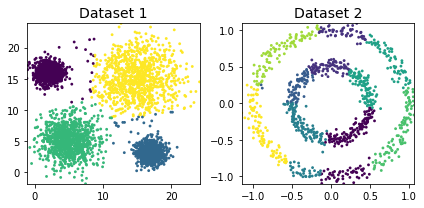

In [7]:
# implementing Mean Shift clustering in python
# auto-calculate bandwidths with estimate_bandwidth
bandwidths = [cluster.estimate_bandwidth(dataset, quantile=0.1) 
                         for dataset in [dataset1, dataset2]]
meanshifts = [cluster.MeanShift(bandwidth=band, bin_seeding=True).fit(dataset) 
              for dataset,band in zip([dataset1,dataset2],bandwidths)]
# print number of clusters for each dataset
print(*["Dataset"+str(i+1)+": "+ str(max(meanshifts[i].labels_)+1) + " clusters" 
        for i in range(2)], sep='\n')
# plot cluster output
cluster_plots(dataset1, dataset2, meanshifts[0].predict(dataset1), meanshifts[1].predict(dataset2))

Mean shift clusters `Dataset1` well, but performs quite poorly on `Dataset2`. This shouldn't be too surprising. It's easy to imagine where you should overlay 4 balls on the first dataset. There's just no way you could accurately partition `Dataset2` with two balls (see the GIF below if you don't believe me). We've only considered a flat kernel (i.e. makes no distinction how the points are distributed within the ball), but, in some cases, a [Gaussian kernel might be more appropriate](http://sociograph.blogspot.co.uk/2011/11/accessible-introduction-to-mean-shift.html). Unfortunately, [scikit currently only accepts flat kernels](https://github.com/scikit-learn/scikit-learn/issues/442), so let's pretend I never mentioned Gaussian kernels. Either way, you'd need some really exotic kernel to identify the two clusters in `Dataset2`. 

![title](https://dashee87.github.io/images/mean_shift_search.gif)

# Affinity Propagation (AP)

Affinity propagation (AP) describes an algorithm that performs clustering by passing messages between points. It seeks to identify highly representative observations, known as exemplars, where remaining data points are assigned to their nearest exemplar. Like mean-shift, the alogorithm does not require the number of clusters to be prespecified. Instead, the user must input two parameters: preference and damping. Preference determines how likely an observation is to become an exemplar, which in turn decides the number of clusters. In that sense, this parameter somewhat mimics the number of clusters parameter in k-means/EM. The damping parameter restricts the magnitude of change between successive updates. Without this, AP can be prone [to overshooting the solution and non-convergence](http://www.psi.toronto.edu/affinitypropagation/faq.html). Provided convergence is achieved, damping shouldn't significantly affect the output (see last GIF in this section), though it could increase the time to reach convergence.

AP doesn't really lend itself to illustration with GIFs. I'll still provide some GIFs, but a mathematical description might be more informative in this case (i.e. I'm now going to paraphrase the [AP wikipedia page](https://en.wikipedia.org/wiki/Affinity_propagation)). AP starts off with a similarity (or affinity) matrix (`S`), where similarity (`s(i,j)`) is often formulated as the distance between points (e.g. negative Euclidean distance). The diagonal of the matrix (`s(i,i)`) is important, as this is where the preference value is inputted. In practice, 'passing messages between points' translates to updating two matrices. The first is the responsibility matrix (`R`), where `r(i,k)` represents the suitability of data point `k` to serve as an exemplar for point `i`. The second matrix is known as the availability matrix (`A`), where `a(i,k)` indicates the appropriateness of point `k` being an exemplar for point `i`, taking into account how well suited `k` is to serve as an exemplar to other points.

![title](https://dashee87.github.io/images/affinity_propagation_similarity.gif)

In mathematical terms, both matrices are initialised to zero and are updated iteratively accroding to the following rules:

$$r(i,k) = s(i,k) -  \max_{k' \neq k} \left\{ a(i, k') + s(i, k') \right \}$$
$$a(i,k)_{i \neq  k} = \min \left( 0, r(k,k) + \sum_{i' \not\in \{i,k\}} \max(0, r(i',k)) \right)$$
$$a(k,k) = \sum_{i' \neq k} \max(0, r(i',k))$$

At each iteration, `A` and `R` are added together. Exemplars are represented by rows in which the diagonal of this matrix are positive (i.e. `r(i,i)` + `s(i,i)` > 0). The algorithm terminates after a specified number of updates or if the exemplars remain unchaged over several iterations. Points are then mapped to the nearest examplar and clustered accordingly.

![title](https://dashee87.github.io/images/affinity_propagation_exemplars.gif)

In [ ]:
# This is killing the Jupyter kernel for some reason, so I disabled it for now.

# # implementing Affinity Propagation
# ap_dataset1 = cluster.AffinityPropagation(verbose=True,random_state=0).fit_predict(dataset1)
# ap_dataset2 = cluster.AffinityPropagation(verbose=True,random_state=0).fit_predict(dataset2)
# print('Dataset1')
# print("# Clusters:",max(ap_dataset1)+1)
# print('Dataset2')
# print("# Clusters:",max(ap_dataset2)+1)
# cluster_plots(dataset1, dataset2, ap_dataset1, ap_dataset2)

It's clear that the default settings in the [sklearn implementation of AP](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html) didn't perform very well on the two datasets (in fact, neither execution converged). AP can suffer from non-convergence, though appropriate calibration of the damping parameter can minimise this risk. While AP doesn't explicitly require you to specify the number of clusters, the preference parameter fulfills this role in practice. Playing around with preference values, you'll notice that AP is considerably slower than k-means. That's because AP runtime complexity is O(n^2), where n represents the number of points in the dataset. But it's not all bad news. AP simply requires a similarity/affinity matrix, so the exact spatial position of each point is irrelevant. This also means that the algorithm is relatively insensitive to high dimensional data, assuming your measure of similarity is robust in higher dimensions (not the case for squared Euclidean distance!). Finally, AP is purely deterministic; so there's no need for multiple random restarts á la kmeans. For all of these reasons, [AP outperforms its competitors](http://science.sciencemag.org/content/315/5814/972) in complex computer visions tasks (e.g. clustering human faces).

In [ ]:
# This is killing the Jupyter kernel for some reason, so I disabled it for now.

# ap_dataset1 = cluster.AffinityPropagation(preference=-10000, damping=0.9, verbose=True,random_state=0).fit_predict(dataset1)
# ap_dataset2 = cluster.AffinityPropagation(preference=-100, damping=0.8, verbose=True,random_state=0).fit_predict(dataset2)
# print('Dataset1')
# print("# Clusters:",max(ap_dataset1)+1)
# print('Dataset2')
# print("# Clusters:",max(ap_dataset2)+1)
# cluster_plots(dataset1, dataset2, ap_dataset1, ap_dataset2)

As you can see, I eventually arrived at some parameters that returned decent clustering for `Dataset1`. And just in case you're curious how the clustering was affected by the parameters.

![title](https://dashee87.github.io/images/affinity_propagation_search.gif)

# DBSCAN

[Density-based spatial clustering of applications with noise](https://en.wikipedia.org/wiki/DBSCAN) (DBSCAN) is a density based clustering algorithm that can neatly handle noise (the clue is in the name). Clusters are considered zones that are sufficiently dense. Points that lack neighbours do not belong to any cluster and are thus classifed as noise (a state that is not immediately attainable under traditional k-means or HC). DBSCAN doesn't require the user to specify the number of clusters; it works that out for you. Instead, the user must define the minimum number of observations that constitutes a cluster (`minPts`) and the size of the neighbourhoods (epsilon- often denoted as `eps` or $\epsilon$). In simple terms, DBSCAN identifies clusters and then expands those clusters by scanning the neighbourhoods of the assigned points. Once all neighbourhoods have been exhausted, the process repeats with a new cluster, until all observations belong to a segment or have been classified as noise (see GIF below).

![title](https://dashee87.github.io/images/DBSCAN_tutorial.gif)

The most obvious advantage of DBSCAN is that the user doesn't need to specify the number of clusters. Also, as already stated, the ability to robustly treat outliers as noise distinguishes it from other techniques. Finally, being density based, DBSCAN can return clusters of any shape.

In [ ]:
# implenting DBSCAN
dbscan_dataset1 = cluster.DBSCAN(eps=1, min_samples=5, metric='euclidean').fit_predict(dataset1)
# noise points are assigned -1
print('Dataset1:')
print("Number of Noise Points: ",sum(dbscan_dataset1==-1)," (",len(dbscan_dataset1),")",sep='')
dbscan_dataset2 = cluster.DBSCAN(eps=0.1, min_samples=5, metric='euclidean').fit_predict(dataset2)
cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)
print('Dataset2:')
print("Number of Noise Points: ",sum(dbscan_dataset2==-1)," (",len(dbscan_dataset2),")",sep='')

Wow! It managed to correctly segment `Dataset2` without knowing number of clusters beforehand. But before you throw k-means in the bin and get a DBSCAN tattoo ([a google image search returned nothing interesting](https://www.google.co.uk/search?q=dbscan+tattoo&safe=off&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjbvJWFz_vRAhUBWhoKHTOrCsAQ_AUICCgB&biw=1600&bih=794)), DBSCAN does have its flaws too. In rare cases, border points can flip between clusters, depending on the order by which the data is processed, meaning different executions can return different outputs. Like all clustering techniques discussed in this tutorial, DBSCAN suffers from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)- distance functions become less meaningful in higher dimensions, as all points are 'far away' from each other. For similar reasons, it can be hard to determine the appropriate values of epsilon and minPts (though trial and error will ususually sffice in 2 dimensions- see below GIF).

![alt-text-2](https://dashee87.github.io/images/DBSCAN_search.gif)

But these concerns are either minor or not unique to DBSCAN. A much bigger issue arises if the clusters exhibit varying density. In such cases, it may be impossible to find a decent epsilon value, as one single value can't perform well on each cluster. This is where [OPTICS](https://en.wikipedia.org/wiki/OPTICS_algorithm) (Ordering points to identify the clustering structure) would come in. Unfortunately, OPTICS isn't currently available in Scikit learn, [though there is a nearly 4 year old (active!) pull request open on github](https://github.com/scikit-learn/scikit-learn/pull/1984). There's also an extension of DBSCAN called [HDBSCAN](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) (where the 'H' stands for Hierarchical, as it incorporates HC). [It overcomes some of DBSCAN traditional faults](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html). However, it's also currently not included in scikit (though there is an [extensively documented python package on github](https://github.com/scikit-learn-contrib/hdbscan)). I might discuss these algorithms in a future blog post.

# Summary

You may be wondering which clustering algorithm is the best. Well, the nature of the data will answer that question. For example, a large dataset could preclude computationally intensive algorithms (e.g hierarchical clustering or affinity propagation). Is anything known about the underlying structure (e.g. globular versus non-globular)? Are you looking for a specific number of clusters? Do you need to illustrate your work with a GIF (I'm looking at you, Affinity Propagation)? So, unfortunately, you need to have various algorithms in your toolbox, ready to deploy as the circumstances dicate (or you could just use k-means for everything).

Hopefully, you enjoyed this tutorial on clustering. I intend to do a few more follow up posts (e.g. how to find the optimal number of clusters). Please get in touch if you have any questions or GIF requests!